# Alzheimer prediction using gray matter density from T1w MRI

**Deadline**: Upload this notebook (rename it as 'TP4-Trees-YOUR-SURNAME.ipynb') with your answers and code to the Moodle/Ecampus before the deadline.


We will use a dataset composed of neuroimaging features from brain T1w MR images of 752 subjects, 416 controls and 336 with Alzheimer’s disease. Following the pipeline described in [1], all images are first normalized to a
common space, providing a voxel-wise correspondence across subjects. Then, gray matter density is computed at each voxel and averaged over a set of ROIs (Region of Interest) of an atlas, at the beginning you will use the [AAL2 atlas](http://www.gin.cnrs.fr/en/tools/aal/). Data comes from several freely available datasets, like [ADNI](http://adni.loni.usc.edu/) and [OASIS](https://www.oasis-brains.org/), and has been pre-processed by the [Clinica](http://www.clinica.run/) team using the procedure explained in [1].

Please load the data from the file: *dataTP.npz* where *T1xxxx* is a matrix containing the averaged density (each row is a subject and each column a feature), *y* is a vector containing the diagnosis (0 for controls and 1 for Alzheimer’s patients) and *ROIlabelsx* contains the name of the ROI of each feature. Here, *x* can take the name of the three atlases you have at your disposal: AAL2, [AICHA](http://www.gin.cnrs.fr/fr/outils/aicha/), [HAMMERS](https://brain-development.org/brain-atlases/adult-brain-atlases/).

**Reference**:
[1] J. Samper-González, N. Burgos, S. Bottani, S. Fontanella, P. Lu, A. Marcoux, A. Routier, J. Guillon, M. Bacci, J. Wen, A. Bertrand, H. Bertin, M.-O. Habert, S. Durrleman, T. Evgeniou, O. Colliot. *Reproducible evaluation of classification methods in Alzheimer's disease: framework and application to MRI and PET data*. NeuroImage, 2018

In [59]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import warnings
warnings.filterwarnings('ignore', category=ImportWarning)

# Libraries
import numpy as np
import matplotlib.pyplot as plt
!pip install -q nilearn
from nilearn import plotting
%matplotlib inline
np.random.seed(seed=666)

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

try:
  import google.colab
  IN_COLAB = True
  print('You are using Google Colab')
  !pip install googledrivedownloader
  from googledrivedownloader import download_file_from_google_drive
except:
  IN_COLAB = False

In [60]:
if IN_COLAB:
    print("you are using google colab")
    download_file_from_google_drive(file_id='11cQmPm64k3T7ml5fPLetZgb1j1AjHBH8',
    dest_path='./dataTP.npz')
    download_file_from_google_drive(file_id='1S7e5IrPygE4VV0JTwqJIlyO2S_NhsiI4',
    dest_path='./AtlasAAL2.nii')
    download_file_from_google_drive(file_id='1E0pu5jIMpgcs2DQ8lBGWliwEBZvKrnV9',
    dest_path='./AtlasAICHA.nii')
    download_file_from_google_drive(file_id='1yltKwULrkHYh79RAh_zAg08r8pQMjRlQ',
    dest_path='./AtlasHAMMERS.nii')

with np.load('./dataTP.npz',allow_pickle=True) as data:
    T1AAL2 = data['T1AAL2'] # data from AAL2 Atlas
    T1AICHA = data['T1AICHA'] # data from AICHA Atlas
    T1HAMMERS = data['T1HAMMERS'] # data from HAMMERS Atlas
    y = data['y'] # classes, 0 for controls and 1 for patients
    ROIlabelsAAL2 = data['ROIlabelsAAL2'] # labels for ROIs of atlas AAL2
    ROIlabelsAICHA = data['ROIlabelsAICHA']    # labels for ROIs of atlas AICHA
    ROIlabelsHAMMERS = data['ROIlabelsHAMMERS']    # labels for ROIs of atlas HAMMERS

In [61]:
# Choose Atlas (here AAL2)
X=T1AAL2 # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsAAL2 # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='AtlasAAL2.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 120


Using the library nilearn we can also plot the atlas used to define the ROIs:

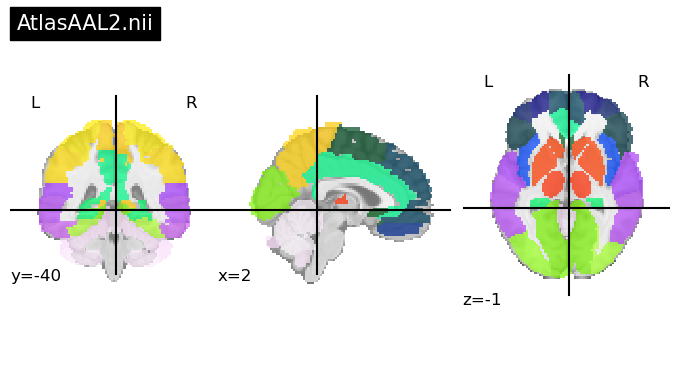

In [62]:
plotting.plot_roi(atlas, title=atlas)
plotting.show()

In this TP we will use Decision Trees, Bagging and Random Forests. Let's start with Decision Trees. First of all, we need to create a training and test set.

In [97]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_train = y_train.ravel()
y_test = y_test.ravel()

And then we need to check whether out features need to be standardized or normalized. Let's have a look at them. Remember that if features can have both negative and positive values, as a rule of thumb, they should be standardized. If they only have positive values, a normalization is usually used.

As already said, please remember that you should learn the standardization/normalization (namely learn the average/std or the max/min values) ONLY in the training set and then use the same values also in the test set. You should NOT use the entire dataset (both training and test) for standardization/normalization. Otherwise, you would have a *data leakage*, namely you would use data (the test set) that you should not use during training.

In [98]:
plt.figure(figsize=(10,10))
plt.boxplot(X,notch=True);

# Standardization/Normalization
from sklearn.preprocessing import Normalizer, StandardScaler
normalizer = Normalizer()
X_train= normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

Then, we can fit a Decision tree, with the default setting, using the following code:

In [99]:
# Fitting Decision Trees
Tree = DecisionTreeClassifier(random_state=0)
Tree.fit(X_train,y_train)
# Score in the training set
print('Score in the training set is {0}'.format(Tree.score(X_train,y_train)))
# Score in the test set
print('Score in the test set is {0}'.format(Tree.score(X_test,y_test)))

Score in the training set is 1.0
Score in the test set is 0.7743362831858407


Instead than using the default hyperparameters, we could also look for the best ones. Among the hyperparameters implemented in *scikit-learn* we could use *'min_samples_split'*, the minimum number of samples required to split an internal node, and/or *'min_samples_leaf'*, the minimum number of samples required to be present at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches.

Plot the training and test score for different values of 'min_samples_split' (for instance between 2 and 15) WITHOUT using Cross Validation. Do the same for 'min_samples_leaf'.

**Question:** What is the best value ? What happens if you split differently your data (change `random_state`in the function `train_test_split`) ?

**Answer:**

The best values for training and test data for min_samples_split are 2 and 10 respectively. For min_samples_leaf the best values are 2 and 15 for training and test data respectively.

If we split our data differently by changing random_state we will get different results for example when multiple splits have the same impurity, DecisionTreeClassifier breaks the tie randomly. Changing random_state affects which split is chosen, leading to a different tree structure. This adds variability even on the same data.

In [114]:
TTest=[]
TTrain=[]
for i in range(2,16):
    Tree = DecisionTreeClassifier(min_samples_split=i, random_state=0)
    Tree.fit(X_train, y_train)
    scoreTrain=Tree.score(X_train, y_train)
    scoreTest=Tree.score(X_test, y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)
plt.plot(TTrain,label='Training score');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_split that maximizes the training score is : ",TTrain.index(max(TTrain))+2)
plt.plot(TTest,label='Test score');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
plt.xlabel('min samples split')
plt.ylabel('score')
print("The value of min_samples_split that maximizes the test score is : ",TTest.index(max(TTest))+2)
plt.legend();

The value of min_samples_split that maximizes the training score is :  2
The value of min_samples_split that maximizes the test score is :  10


In [101]:
# min_samples_leaf
TTest=[]
TTrain=[]
for i in range(2,16):
    Tree = DecisionTreeClassifier(min_samples_split=4, min_samples_leaf=i, random_state=0)
    Tree.fit(X_train, y_train)
    scoreTrain=Tree.score(X_train, y_train)
    scoreTest=Tree.score(X_test, y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)
plt.plot(TTrain,label='Training score');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_leaf that maximizes the training score is : ",TTrain.index(max(TTrain))+2)
plt.plot(TTest,label='Test score');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
plt.xlabel('min samples split')
plt.ylabel('score')
print("The value of min_samples_leaf that maximizes the test score is : ",TTest.index(max(TTest))+2)
plt.legend();

The value of min_samples_leaf that maximizes the training score is :  2
The value of min_samples_leaf that maximizes the test score is :  15


Try to add Gaussian noise to the data (using for instance zero mean and 0.02 for $\sigma$) and, using the best hyperparameters found before in the test set (you can use both `min_samples_leaf` and `min_samples_split`), look at the test score. Repeat this process several times and compare the results with the score obtained without adding noise.

**Question**: Are the results stable ? Hint: you could use for instance *noise = np.random.normal(mu, sigma)* if you have standardized the features and *noise = np.abs(np.random.normal(mu, sigma))* if you have normalized them (we use *np.asb()* to take only positive values and $\sigma$ should be small in order to (almost) preserve the range of the features between 0 and 1)

**Answer:**

The results are not stable, by the looking at the graph we can see that the noisy data oscilites a lot in comparison with the original data and the score results drop to 0.43

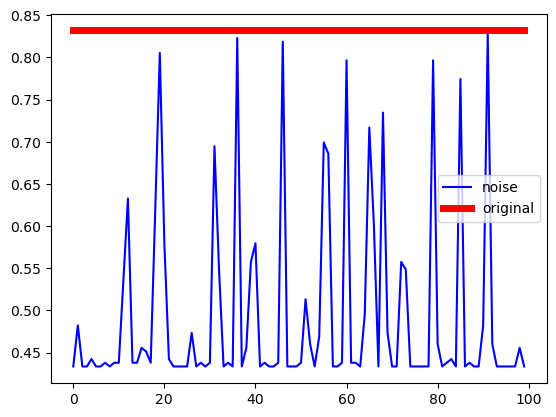

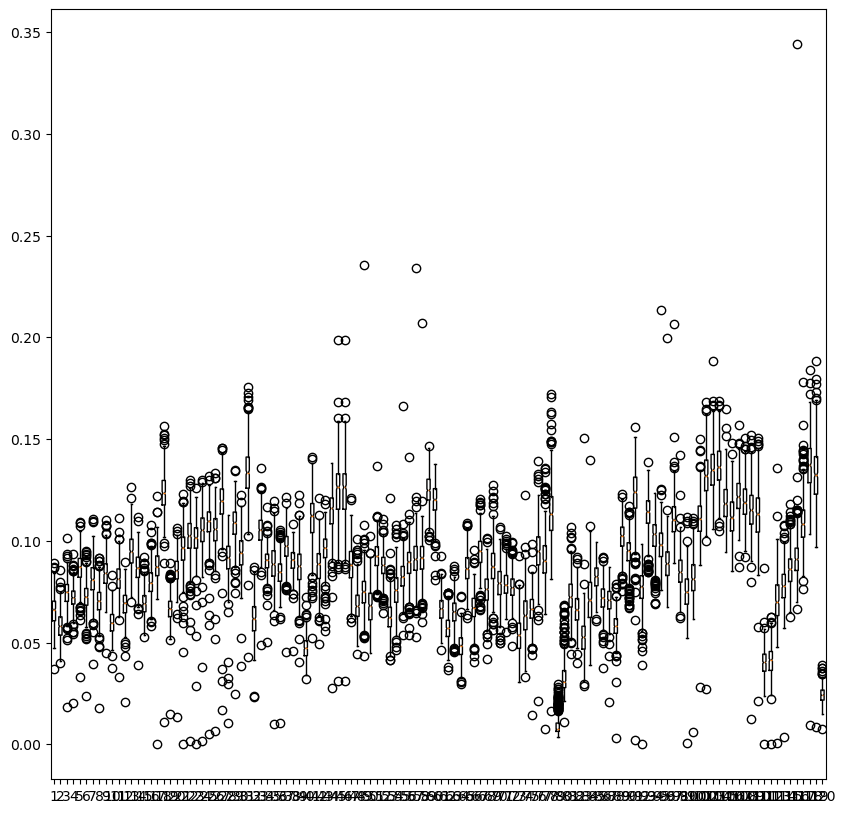

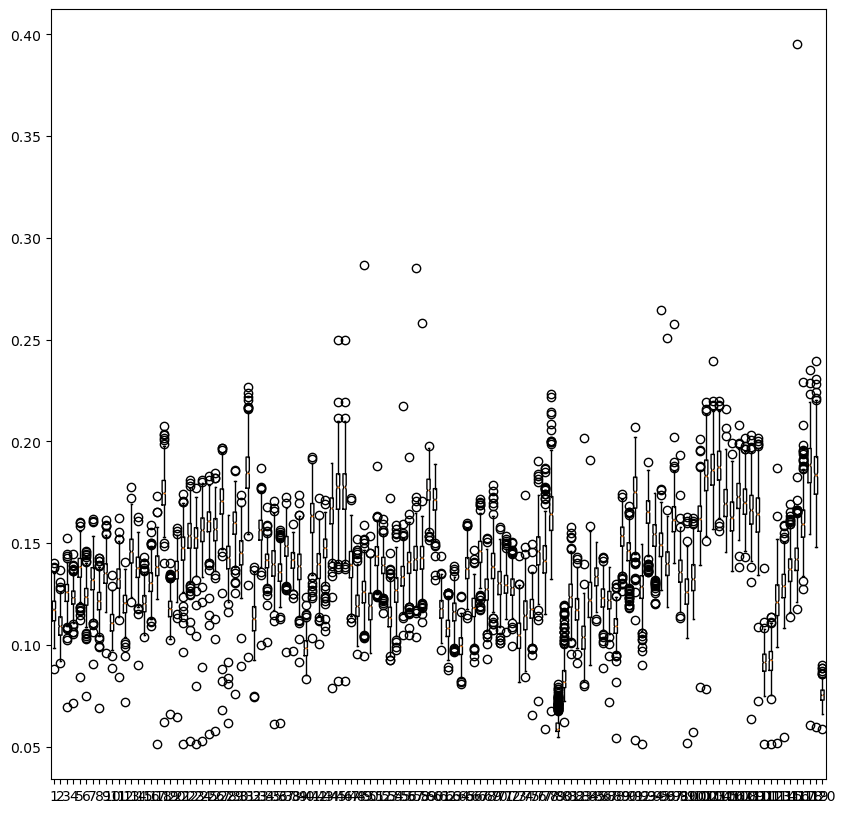

Score on the test data when training the tree with noisy data: 0.4336283185840708


In [123]:
Tree = DecisionTreeClassifier(min_samples_split=10,min_samples_leaf=15,random_state=0)
scoreTestnoise=np.zeros(100)
scoreTest=np.zeros(100)

Tree.fit(X_train,y_train)
scoreTest[:] = Tree.score(X_test,y_test)

for k in range(100):
    X_train_temp=np.copy(X_train)
    X_train_temp += np.abs(np.random.normal(0,0.02))

    Tree.fit(X_train_temp,y_train)
    scoreTestnoise[k] = Tree.score(X_test, y_test)

plt.plot(scoreTestnoise,'b',label='noise')
plt.plot(scoreTest,'r',linewidth=5.0,label='original')
plt.legend();

plt.figure(figsize=(10,10))
plt.boxplot(X_train,notch=True);

plt.figure(figsize=(10,10))
plt.boxplot(X_train_temp,notch=True);
plt.show()
print('Score on the test data when training the tree with noisy data:', Tree.score(X_test,y_test))

To plot decision trees, we can also use the *graphviz* library. If you need to install it locally, you can do it using *conda install python-graphviz*.


First plot the tree learnt on the original data, witout adding noise.

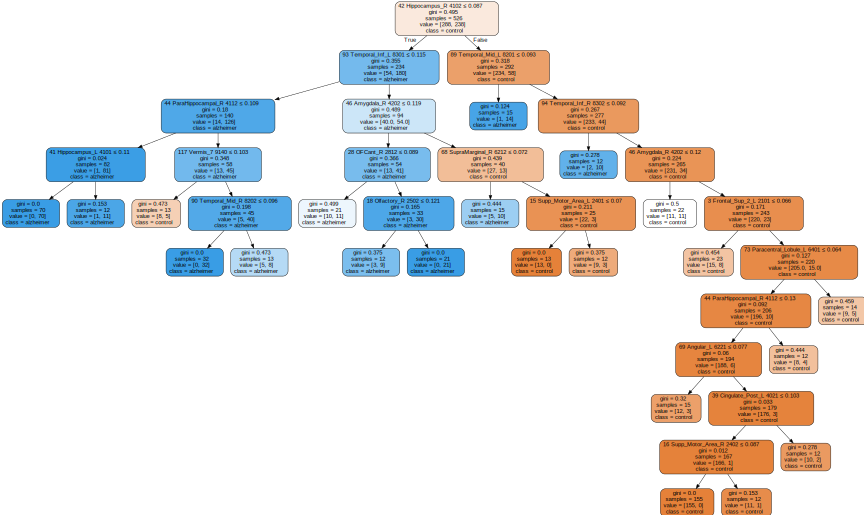

In [103]:
import graphviz

Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
dot_data = 'digraph Tree {size="12";' + dot_data.split('{', 1)[1]
graph = graphviz.Source(dot_data)
graph

Now, plot the tree learnt on noisy data.

**Question**: Is it the same ? You can try several times, for different levels of noise. Comment the results

**Answer:**

The Tree graph is not the same, it is very different in fact. We can observe a much higher ramification for False Labels in the Tree that was fitted with noisy data than the one fitted with original data. 

The splitting for True Labels in the noisy Tree is very small.

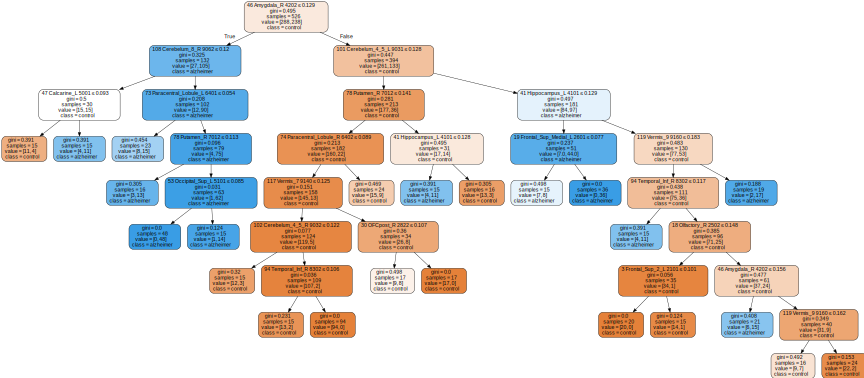

In [129]:
X_train_temp = np.copy(X_train)
for i in range(X_train.shape[0]):
    mu = 0
    sigma = 0.02
    noise = np.abs(np.random.normal(mu, sigma))
    X_train_temp[i] += noise
Tree.fit(X_train_temp,y_train)
dot_data2 = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
dot_data2 = 'digraph Tree {size="12";' + dot_data2.split('{', 1)[1]
graph = graphviz.Source(dot_data2)
graph

Instead than using a single split of the data, we could also use Cross Validation to compute the best hyperparameter values for both 'min_samples_split' and 'min_samples_leaf' at the same time and in an automatic way.

**Question:** Do you find the same optimal hyperparameters as before ? Hint: use GridSearchCV

**Answer:**

No, the parameters found to be the best using GridSearch are different from those using the "for loop method" testing. 



**Question:** So far, we have used the standard score (ie accuracy). Would you use a different one ? If yes, which one and why ?

**Answer:**

Yes, I would use additional metrics beyond accuracy, especially for medical diagnosis where the cost of misclassification is high. Metrics like F1-score, recall, and ROC AUC are more informative.

- Recall is crucial to minimize false negatives (missing Alzheimer's cases).
- F1-score balances recall and precision, useful when classes are imbalanced.
- ROC AUC evaluates the model's ability to distinguish between classes across all thresholds, providing a robust measure of performance.

In [130]:
Tree = DecisionTreeClassifier()
split_val = [i for i in range(2,20)]
p_grid_tree = {'min_samples_split': split_val, 'min_samples_leaf': split_val}
grid_tree = GridSearchCV(Tree, p_grid_tree)
grid_tree.fit(X_train, y_train)
print("Best Validation Score: {}".format(grid_tree.best_score_))
print("Best params: {}".format(grid_tree.best_params_))
print("Tree test score :",grid_tree.score(X_test, y_test))

best_params=grid_tree.best_params_

Best Validation Score: 0.7985085354896676
Best params: {'min_samples_leaf': 13, 'min_samples_split': 2}
Tree test score : 0.8097345132743363


Using the estimated optimal hyperparameters, plot the new decision tree using the *graphviz* library.

**Question**: Is it the same as before? Do you see ROIs that are always close to the root of the tree among the different experiments ? If yes, what does it mean in your opinion ? Comment the results.


**Answer:**

The trees are different, the one using the best hyperparameters is smaller and simpler. Since its test score is better and the tree is less complex, it shows that this version is better than the previous one.

We also see the same ROIs appearing close to the root in both trees. This suggests that these ROIs are probably the most important features, and they help the model make good predictions for most of the subjects.

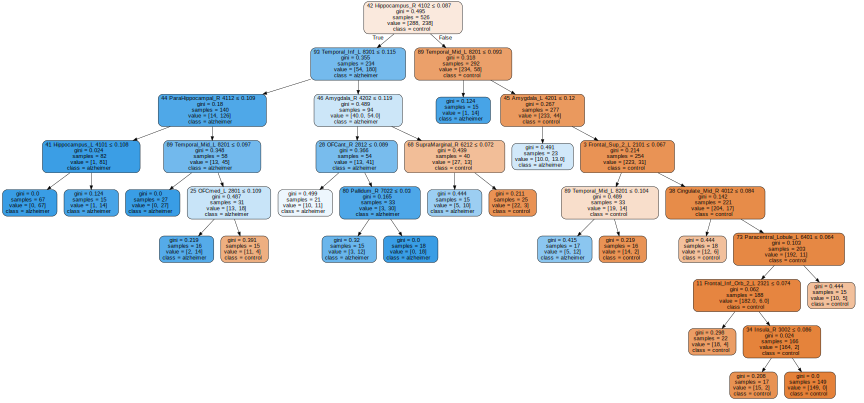

In [131]:
Tree = DecisionTreeClassifier(min_samples_split = 2, min_samples_leaf = 15, random_state=0)
Tree.fit(X_train, y_train)

dot_data3 = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
dot_data3= 'digraph Tree {size="12";' + dot_data3.split('{', 1)[1]
graph = graphviz.Source(dot_data3)
graph

Try to use now Bagging. You can use the following code where we use the previously computed best parameters 'min_samples_leaf' and 'min_samples_split'.

**Question**: What happens when you use the original data and the noisy version ? Do you notice any difference in the prediction scores with respect to the results using Decision Trees ?

**Answer:**

Both the original and noisy data show a big improvement in prediction scores when using Bagging, especially for the noisy data.

### On the original data:
- **Best Validation Score:** 0.844  
- **Best Params:** `{'n_estimators': 50}`  
- **Bagging Test Score:** 0.867

### On the noisy data:
- **Best Validation Score:** 0.778  
- **Best Params:** `{'n_estimators': 30}`  
- **Bagging Test Score:** 0.761

There’s a clear difference compared to using a single `DecisionTreeClassifier`. Bagging gives much better results by reducing overfitting and improving model stability, especially when the data is noisy.


In [132]:
Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20,25,30,50,100]}
bag=BaggingClassifier(estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging)
grid_bagging.fit(X_train, y_train.ravel())
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test,y_test))

Best Validation Score: 0.8440790655884995
Best params: {'n_estimators': 50}
Bagging test score : 0.8672566371681416


In [133]:
# Bagging on noisy data
p_grid_bagging = {'n_estimators': [5,10,15,20,25,30,50,100]}
bag=BaggingClassifier(estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging)
grid_bagging.fit(X_train_temp, y_train.ravel())
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test,y_test))

Best Validation Score: 0.7775741239892183
Best params: {'n_estimators': 30}
Bagging test score : 0.7610619469026548


The last part of this TP is about Random Forests. We can estimate the three hyperparameters *'n_estimators'*, *'min_samples_leaf'* and *'max_features'*, the number of features to consider when looking for the best split, as before using Cross Validation

In [109]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30,50], 'min_samples_leaf': [2,3,4,5,6,10,11,12], 'max_features': ['sqrt','log2']}

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='roc_auc', cv=5)
grid_RF.fit(X_train, y_train.ravel())

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("Random Forest test score :",grid_RF.score(X_test,y_test))

Best Validation Score: 0.9170813167977414
Best params: {'max_features': 'log2', 'min_samples_leaf': 3, 'n_estimators': 50}
Random Forest test score : 0.9299266581632653


Using the estimated best hyperparameters, test the performance of Random Forest on the noisy data and compare the results with Decision Trees and Bagging.

In [110]:
# Random Forest on noisy data
RF = RandomForestClassifier(n_estimators = 50, min_samples_leaf=3, max_features='log2', random_state=0)
RF.fit(X_train_temp, y_train.ravel())
print('Test Score for noisy data is:', RF.score(X_test, y_test))

Test Score for noisy data is: 0.7964601769911505


We can also use Random Forests to check the importance of the features

Feature ranking:
1. feature 44 representing 45 Amygdala_L 4201
 (0.091315)
2. feature 40 representing 41 Hippocampus_L 4101
 (0.060042)
3. feature 43 representing 44 ParaHippocampal_R 4112
 (0.057832)
4. feature 45 representing 46 Amygdala_R 4202
 (0.051031)
5. feature 41 representing 42 Hippocampus_R 4102
 (0.035070)
6. feature 89 representing 90 Temporal_Mid_R 8202
 (0.032566)
7. feature 92 representing 93 Temporal_Inf_L 8301
 (0.029080)
8. feature 93 representing 94 Temporal_Inf_R 8302
 (0.027462)
9. feature 100 representing 101 Cerebelum_4_5_L 9031
 (0.024171)
10. feature 88 representing 89 Temporal_Mid_L 8201
 (0.019310)


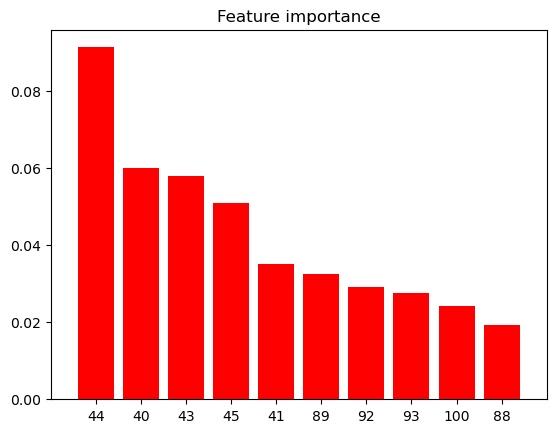

In [111]:
best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train, y_train.ravel())

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

**Question**: Which are the most important features (i.e. ROIs) ?  Based on the two given research papers, you can verify if your results make sense.

**Answer:**

The four most important features found by the model are in order of importance:

    Feature 44: 45 Amygdala_L 4201 
    Feature 40: 41 Hippocampus_L 4101 
    Feature 43: 44 ParaHippocampal_R 4112
    Feature 45: 46 Amygdala_R 4202
    
This matches what the research papers say, as they also point out that the amygdala, hippocampus and Parahippocampal Gyrus are key brain regions affected in Alzheimer’s disease. So the model is focusing on the right areas, which makes the results more reliable.

We can also inspect the data using only pairs of the most important features

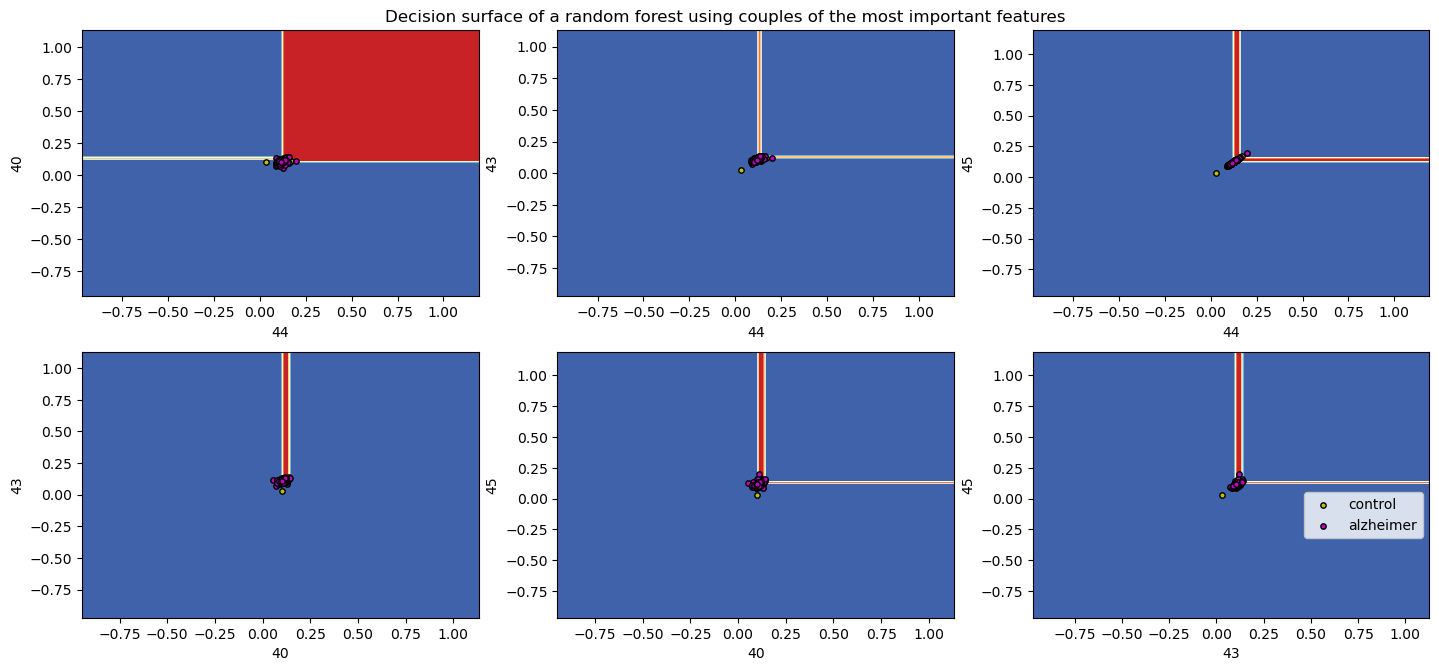

In [134]:
plt.figure(figsize=(15,7))
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train

    # Train
    clf = RF.fit(Xpair, ypair)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "ym"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i], edgecolor='black', s=15)

plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()

**Question**: Which is the best couple of features ?


**Answer:**

From these subplots, the best pair of features seems to be 40 and 44 (top-left plot). They yield a clear boundary with minimal overlap between the two classes, indicating that these two features together have strong discriminative power for distinguishing Alzheimer’s patients from controls.



**Different Atlas**

Previously, we have used the AAL2 which defines a precise split of the brain into ROIs. What happens if you change Atlas ? Do you obtain the same results ? Can you find a subset of ROIs that you could define 'biomarkers' of the Alzheimer's disease ? Justify your answer and check whether it makes sense by using the two given research papers.

You can use the AICHA (http://www.gin.cnrs.fr/fr/outils/aicha/) and HAMMERS (https://brain-development.org/brain-atlases/adult-brain-atlases/) atlas.